In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from scipy.stats import stats
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3d projection

In [2]:
class Customerchurn:
    """
    A class for performing exploratory customer churn analysis with pandas and visualization libraries.

    Attributes
    ----------
    t_df : pd.DataFrame
        The main DataFrame containing telco customer churn data.

    Methods
    -------
    data_frame()
        Returns the raw DataFrame.
    null_values()
        Returns missing value counts per column.
    info()
        Prints DataFrame info summary.
    value_count(col)
        Returns value counts for a specific column.
    type_conversion()
        Converts 'TotalCharges' column to numeric type.
    describe_values()
        Returns summary statistics for numerical columns.
    fill_null_values()
        Fills missing values with 2283 (max 11 per column).
    avg_monthly_total_charges()
        Groups by 'Churn' and prints mean monthly/total charges.
    Chi_Square_test(col1, col2)
        Performs chi-square test between two categorical columns.
    ANOVA()
        Performs ANOVA on numeric columns grouped by Churn.
    correlation_matrix()
        Calculates and prints the correlation matrix.
    add_tenure_group()
        Creates tenure bins as new column.
    plot_tenure_group()
        Plots customer count per tenure group.
    plot_hist(col)
        Plots histogram for a numeric feature.
    bar_chart_churn_by_contract()
        Plots bar chart of Churn by Contract type.
    Churn_countplot()
        Plots countplot of Churn distribution.
    plot_3d_scatter_plotly(x_col, y_col, z_col, color_col)
        Interactive 3D scatterplot (Plotly).
    churn_status_by_monthly()
        Plots average MonthlyCharges by Churn.
    plot_pie_chart(col)
        Plots pie chart of value distribution for a column.
    plot_churn_percentage_by_internetservice()
        Pie charts of churn percentage by InternetService type.
    pairplot()
        Pairplot of tenure, charges colored by Churn.
    plot_avg_Total_charges_by_churn()
        Barplot of average TotalCharges by Churn.
    """

    def __init__(self, t_df):
        """Initialize the class with the provided churn DataFrame."""
        self.t_df = t_df

    def data_frame(self):
        """Return the raw churn DataFrame for external analysis."""
        return self.t_df

    def null_values(self):
        """Count and return the number of missing values in each column of the data."""
        return self.t_df.isnull().sum()

    def info(self):
        """Print concise summary of DataFrame structure, column types, and null counts."""
        return self.t_df.info()

    def value_count(self, col):
        """
        Returns counts of unique values in the specified column.

        Parameters
        ----------
        col : str
            Name of the column to count values.

        Returns
        -------
        pandas.Series
            Series of value counts per category.
        """
        if col in self.t_df.columns:
            return self.t_df[col].value_counts()

    def type_conversion(self):
        """Convert the 'TotalCharges' column to numeric type, coercing errors to NaN."""
        self.t_df['TotalCharges'] = pd.to_numeric(self.t_df['TotalCharges'], errors='coerce')

    def describe_values(self):
        """Return descriptive statistics for all numerical columns in the DataFrame."""
        return self.t_df.describe()

    def fill_null_values(self):
        """Fill up to 11 missing values per column with 2283 inplace; does not return anything."""
        self.t_df.fillna(2283, limit=11, inplace=True)

    def avg_monthly_total_charges(self):
        """
        Group by 'Churn' and print the mean of 'MonthlyCharges' and 'TotalCharges'.

        Converts necessary columns to numeric before aggregation.
        """
        self.t_df['MonthlyCharges'] = pd.to_numeric(self.t_df['MonthlyCharges'], errors='coerce')
        self.t_df['TotalCharges'] = pd.to_numeric(self.t_df['TotalCharges'], errors='coerce')
        grouped_means = self.t_df.groupby('Churn')[['MonthlyCharges', 'TotalCharges']].mean()
        print(grouped_means)

    def Chi_Square_test(self, col1, col2):
        """
        Perform Chi-Square test for independence between two categorical columns.

        Returns a dictionary with statistic, p-value, degrees of freedom, and expected frequencies.
        """
        contingency_table = pd.crosstab(self.t_df[col1], self.t_df[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        return {
            'chi2_statistic': chi2,
            'p_value': p,
            'degrees_of_freedom': dof,
            'expected_freq': expected
        }

    def ANOVA(self):
        """
        Perform ANOVA for all numeric columns, grouped by 'Churn', and print F, p-values.
        """
        continuous_vars = self.t_df.select_dtypes(['int64','float64']).columns.tolist()
        target = 'Churn'
        for col in continuous_vars:
            data = self.t_df[[col, target]].dropna()
            groups = [group[col].values for name, group in data.groupby(target)]
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"ANOVA for {col} by {target}: F = {f_stat:.3f}, p = {p_val:.3e}")

    def correlation_matrix(self):
        """
        Calculate and print the correlation matrix for all numeric columns in the DataFrame.

        Returns
        -------
        pandas.DataFrame
            Correlation matrix of numeric features.
        """
        corr_matrix = self.t_df.corr(numeric_only=True)
        print(corr_matrix)
        return corr_matrix

    def add_tenure_group(self):
        """
        Bin the 'tenure' column into tenure categories and add them as a new column 'TenureGroup'.

        Returns
        -------
        pandas.DataFrame
            DataFrame with new 'TenureGroup' column.
        """
        self.t_df['TenureGroup'] = pd.cut(self.t_df['tenure'],
            bins=[0, 12, 24, 48, 72],
            labels=['0-12', '12-24', '24-48', '48-72'])
        return self.t_df

    def plot_tenure_group(self):
        """Visualize number of customers in each tenure category using a countplot."""
        sns.countplot(x='TenureGroup', data=self.t_df)
        plt.xlabel('Tenure Group (months)')
        plt.ylabel('Number of Customers')
        plt.title('Customers per Tenure Group')
        plt.show()

    def plot_hist(self, col):
        """
        Plot a histogram displaying the distribution of a given numeric feature.

        Parameters
        ----------
        col : str
            Name of numeric column to plot.
        """
        sns.histplot(self.t_df[col], bins=30)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'{col} Distribution')
        plt.show()

    def bar_chart_churn_by_contract(self):
        """Plot a bar chart showing churn counts split by contract type."""
        sns.countplot(x='Contract', hue='Churn', data=self.t_df)
        plt.title('Churn by Contract Type')
        plt.show()

    def Churn_countplot(self):
        """Generate a countplot visualizing overall churn distribution."""
        sns.countplot(x='Churn', data=self.t_df)
        plt.title('Churn Distribution')
        plt.show()

    def plot_3d_scatter_plotly(self, x_col, y_col, z_col, color_col=None):
        """
        Create a 3D scatter plot using Plotly for the specified dimensions.

        Parameters
        ----------
        x_col, y_col, z_col : str
            Column names to use as scatter axes.
        color_col : str, optional
            Column name for coloring points.
        """
        fig = px.scatter_3d(
            self.t_df,
            x=x_col,
            y=y_col,
            z=z_col,
            color=color_col,
            title=f'3D Scatter Plot: {x_col} vs {y_col} vs {z_col}'
        )
        fig.show()

    def churn_status_by_monthly(self):
        """Bar plot depicting average monthly charges grouped by churn status."""
        sns.barplot(x='Churn', y='MonthlyCharges', data=self.t_df)
        plt.title('Average Monthly Charges by Churn Status')
        plt.show()

    def plot_pie_chart(self, col):
        """
        Plot a pie chart visualizing the distribution of categories in the specified column.

        Parameters
        ----------
        col : str
            Categorical column for pie chart visualization.
        """
        counts = self.t_df[col].value_counts()
        plt.figure(figsize=(7,7))
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.title(f'Distribution of {col}')
        plt.axis('equal')
        plt.show()

    def plot_churn_percentage_by_internetservice(self):
        """
        Plot pie charts showing churn percentages inside each InternetService category.
        Creates separate pie charts per InternetService type.
        """
        categories = self.t_df['InternetService'].unique()
        for cat in categories:
            subset = self.t_df[self.t_df['InternetService'] == cat]
            churn_counts = subset['Churn'].value_counts(normalize=True) * 100
            labels = churn_counts.index
            sizes = churn_counts.values

            plt.figure(figsize=(6,6))
            plt.pie(
                sizes,
                labels=labels,
                autopct='%1.1f%%',
                startangle=140,
                colors=['#ff9999','#66b3ff']
            )
            plt.title(f'Churn Percentage for InternetService: {cat}')
            plt.axis('equal')
            plt.show()

    def pairplot(self):
        """
        Draw a pairplot of tenure, MonthlyCharges, and TotalCharges.
        Colors data points by 'Churn' status for visual feature comparison.
        """
        sns.pairplot(self.t_df, hue='Churn', vars=['tenure', 'MonthlyCharges', 'TotalCharges'])
        plt.show()

    def plot_avg_Total_charges_by_churn(self):
        """Bar plot showing average TotalCharges by churn status."""
        sns.barplot(x='Churn', y='TotalCharges', data=self.t_df)
        plt.title('Average Total Charges by Churn Status')
        plt.show()

    @staticmethod
    def infer_sql_type(dtype):
        """
        Infer the corresponding SQL data type for a given pandas dtype.
    
        Parameters:
        -----------
        dtype : pandas dtype
            The data type of a pandas DataFrame column.
    
        Returns:
        --------
        str
            The corresponding SQL data type as a string.
            Possible returned types: "INT", "FLOAT", "BOOLEAN", "TIMESTAMP", "TEXT".
        """
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"

    def generate_create_table_statement(self, table_name="Telco_Customer_Churn_Data"):
        """
        Generate a SQL CREATE TABLE statement based on the DataFrame's column data types.
    
        Parameters:
        -----------
        table_name : str, optional
            The name of the SQL table to be created (default is "Telco_Customer_Churn_Data").
    
        Returns:
        --------
        str
            A SQL string for creating the table with appropriate column types inferred from the DataFrame.
        """
        columns = self.t_df.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
            {sql_columns}
        );
        """
        return create_stmt

    def save_to_postgres(self, conn_params, table_name="Telco_Customer_Churn_Data"):
        """
        Create the table (if not exists) and insert DataFrame records into PostgreSQL.
    
        Parameters:
        -----------
        conn_params : dict
            Dictionary containing PostgreSQL connection parameters with keys:
            'dbname', 'user', 'password', 'host', 'port'.
        table_name : str, optional
            Target table name in the database (default is "Telco_Customer_Churn_Data").
    
        Behavior:
        ---------
        - Connects to PostgreSQL using provided parameters.
        - Executes the CREATE TABLE statement generated from the DataFrame schema.
        - Inserts each row of the DataFrame into the specified table.
        - Commits the transaction and closes the connection.
        - Prints a success message or error if operation fails.
        """
        create_stmt = self.generate_create_table_statement(table_name)
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            # Create table
            cur.execute(create_stmt)
            conn.commit()
            # Prepare insert statement
            columns = list(self.t_df.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
        """
            # Insert rows
            for _, row in self.t_df.iterrows():
                cur.execute(insert_stmt, tuple(row))
            conn.commit()
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")
        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")

In [6]:
# Load the data
t_df = pd.read_csv('Telco_Customer_Churn_Data.csv')
t_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [7]:
# Initialize the analysis class
churn_t = Customerchurn(t_df)
churn_t

In [8]:
churn_t.data_frame()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [9]:
churn_t.null_values()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
churn_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
churn_t.value_count('Churn')

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [12]:
churn_t.type_conversion()

In [13]:
churn_t.describe_values()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [14]:
churn_t.null_values()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [15]:
churn_t.fill_null_values()

In [16]:
churn_t.null_values()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
churn_t.avg_monthly_total_charges()

       MonthlyCharges  TotalCharges
Churn                              
No          61.265124   2554.765133
Yes         74.441332   1531.796094


In [18]:
churn_t.Chi_Square_test('InternetService','Churn') #This extremely small p-value indicates strong evidence against the null hypothesis of independence. It means the association between the two variables is statistically significant.

{'chi2_statistic': np.float64(732.309589667794),
 'p_value': np.float64(9.571788222840544e-160),
 'degrees_of_freedom': 2,
 'expected_freq': array([[1778.53954281,  642.46045719],
        [2274.41488002,  821.58511998],
        [1121.04557717,  404.95442283]])}

In [19]:
churn_t.ANOVA()

ANOVA for SeniorCitizen by Churn: F = 164.041, p = 3.840e-37
ANOVA for tenure by Churn: F = 997.268, p = 7.999e-205
ANOVA for MonthlyCharges by Churn: F = 273.464, p = 2.707e-60
ANOVA for TotalCharges by Churn: F = 291.629, p = 4.235e-64


C:\Users\hi\AppData\Local\Temp\ipykernel_25916\3907835585.py:138: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_25916\3907835585.py:138: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_25916\3907835585.py:138: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\hi\AppData\Local\Temp\ipykernel_25916\3907835585.py:138: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is depre

In [20]:
churn_t.correlation_matrix()

                SeniorCitizen    tenure  MonthlyCharges  TotalCharges
SeniorCitizen        1.000000  0.016567        0.220173      0.102395
tenure               0.016567  1.000000        0.247900      0.824758
MonthlyCharges       0.220173  0.247900        1.000000      0.650468
TotalCharges         0.102395  0.824758        0.650468      1.000000


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.102395
tenure,0.016567,1.000000,0.247900,0.824758
MonthlyCharges,0.220173,0.247900,1.000000,0.650468
TotalCharges,0.102395,0.824758,0.650468,1.000000


In [21]:
churn_t.add_tenure_group()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,24-48
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,24-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,12-24
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,48-72
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0-12
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,0-12


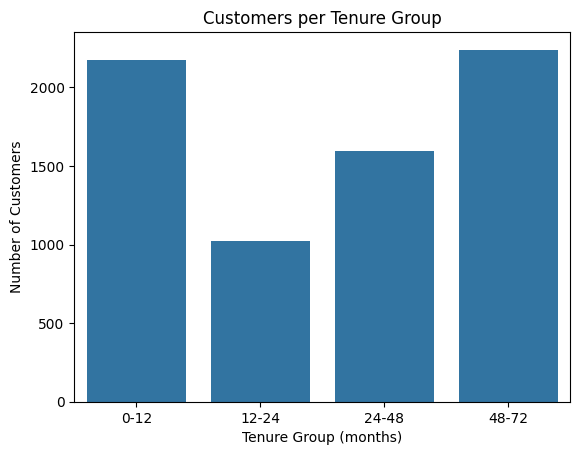

In [22]:
churn_t.plot_tenure_group()

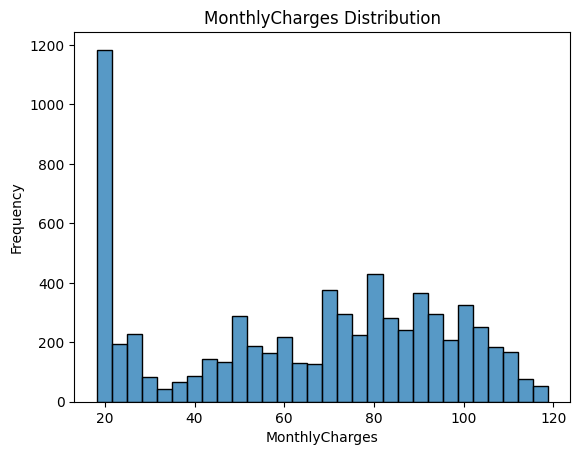

In [23]:
churn_t.plot_hist("MonthlyCharges")

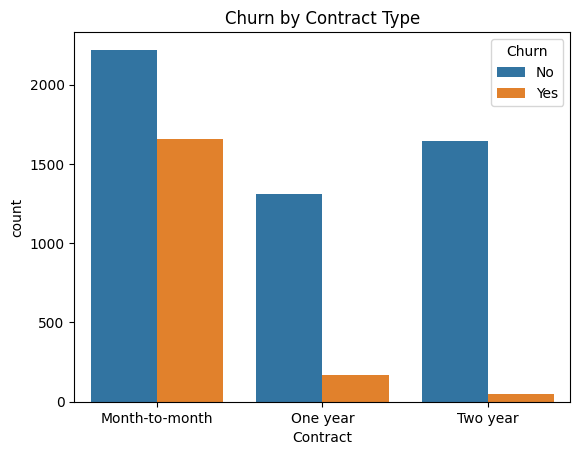

In [24]:
churn_t.bar_chart_churn_by_contract()

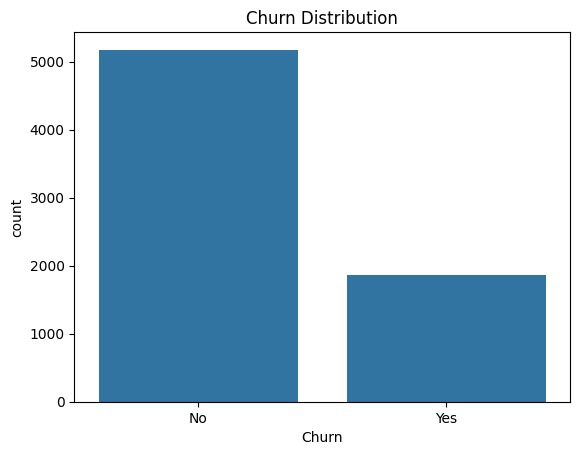

In [25]:
churn_t.Churn_countplot()

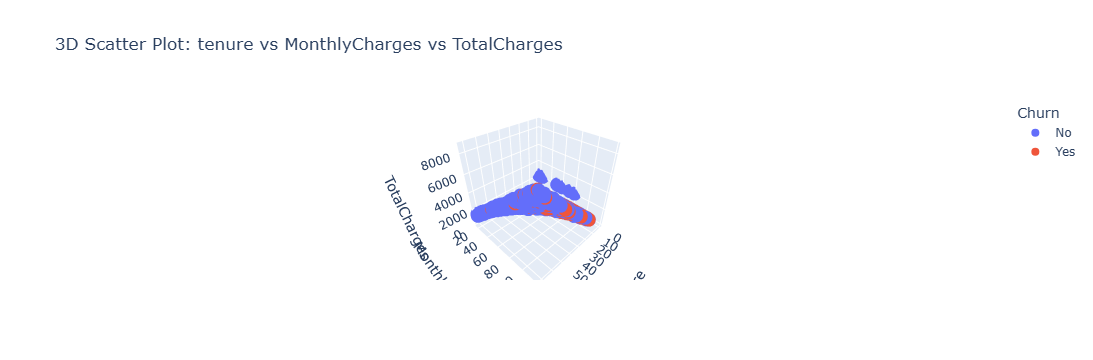

In [26]:
churn_t.plot_3d_scatter_plotly('tenure', 'MonthlyCharges', 'TotalCharges', 'Churn')

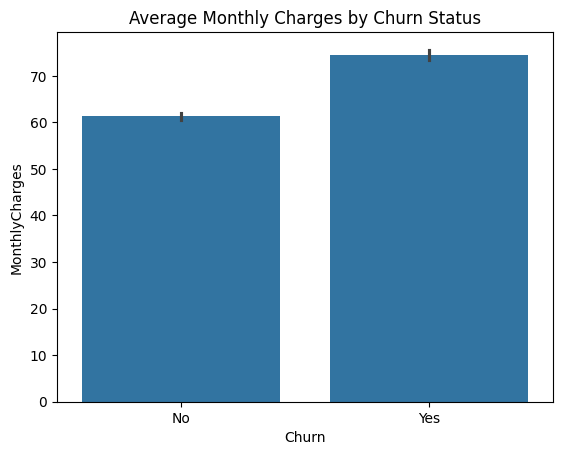

In [27]:
churn_t.churn_status_by_monthly()

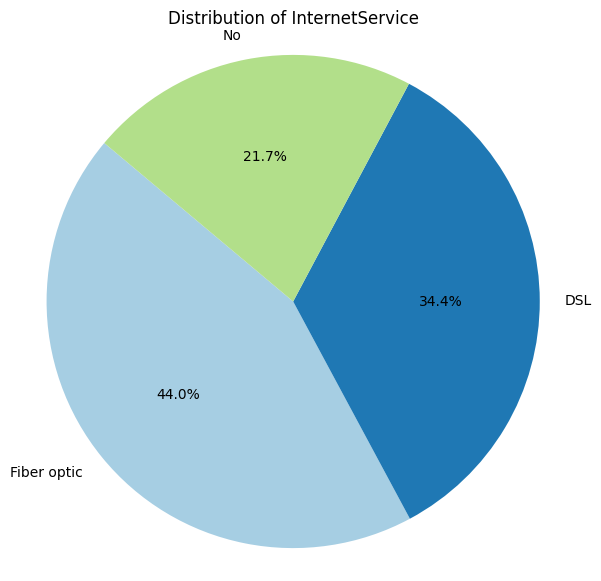

In [28]:
churn_t.plot_pie_chart("InternetService")

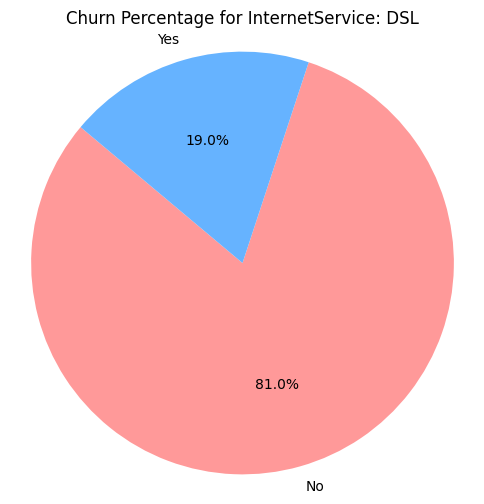

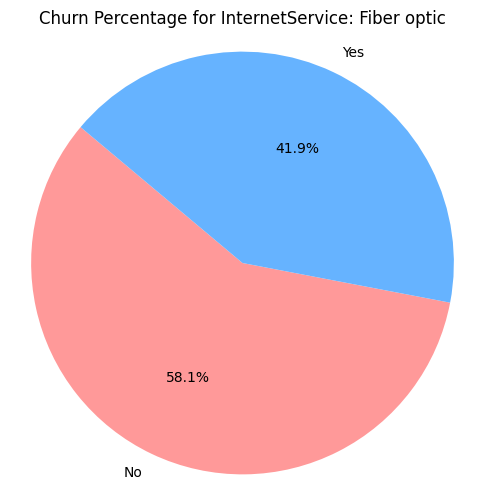

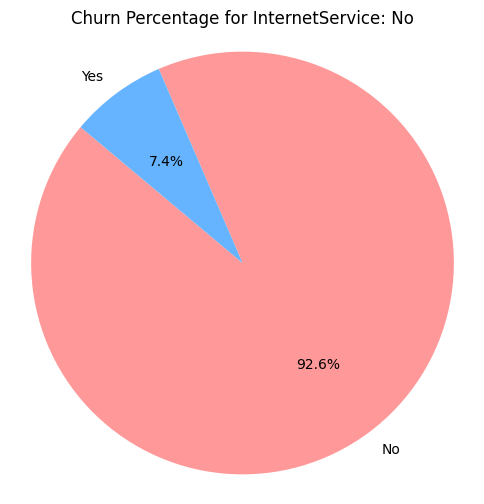

In [29]:
churn_t.plot_churn_percentage_by_internetservice()

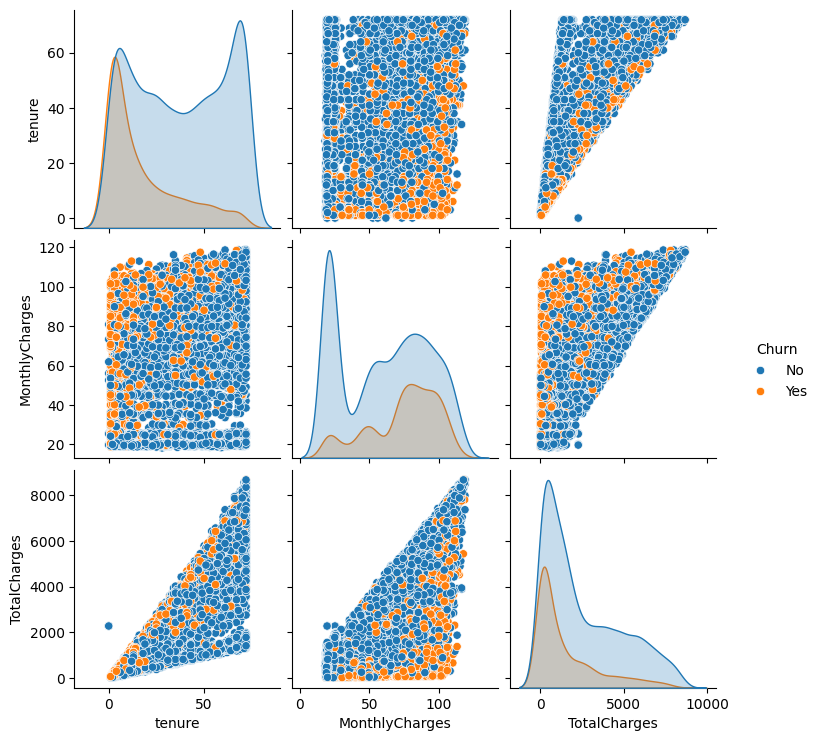

In [30]:
churn_t.pairplot()

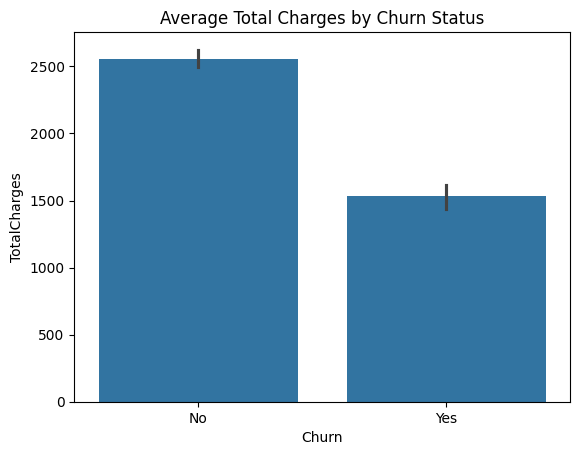

In [31]:
churn_t.plot_avg_Total_charges_by_churn()

In [32]:
print(churn_t.generate_create_table_statement())


            CREATE TABLE IF NOT EXISTS Telco_Customer_Churn_Data (
            "customerID" TEXT,
    "gender" TEXT,
    "SeniorCitizen" INT,
    "Partner" TEXT,
    "Dependents" TEXT,
    "tenure" INT,
    "PhoneService" TEXT,
    "MultipleLines" TEXT,
    "InternetService" TEXT,
    "OnlineSecurity" TEXT,
    "OnlineBackup" TEXT,
    "DeviceProtection" TEXT,
    "TechSupport" TEXT,
    "StreamingTV" TEXT,
    "StreamingMovies" TEXT,
    "Contract" TEXT,
    "PaperlessBilling" TEXT,
    "PaymentMethod" TEXT,
    "MonthlyCharges" FLOAT,
    "TotalCharges" FLOAT,
    "Churn" TEXT,
    "TenureGroup" TEXT
        );
        


In [33]:
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "901473R",
    'host': "localhost",
    'port': "5432"
}
churn_t.save_to_postgres(conn_params)

Data inserted successfully into table Telco_Customer_Churn_Data
